## 1. Data Pre-processing

In [1]:
from src.learnlibs.preproc import *
from src.learnlibs.meanfill import *
from src.learnlibs.model import *
from src.learnlibs.read_data import *
from src.learnlibs.create_features import *
from src.learnlibs.splitdata import *

### Load dataset

In [2]:
df_full = loader("Levels_Fyi_Salary_Data.csv").load()
# remove not useful columns
df = df_full[['timestamp', 'company', 'level', 'title', 'location', 'yearsofexperience', 'yearsatcompany', 'tag', 'basesalary', 'gender', 'Race', 'Education']]
df.head()

,timestamp,company,level,title,location,yearsofexperience,yearsatcompany,tag,basesalary,gender,Race,Education
0,6/7/2017 11:33:27,Oracle,L3,Product Manager,"Redwood City, CA",1.5,1.5,NaN,107000.0,NaN,NaN,NaN
1,6/10/2017 17:11:29,eBay,SE 2,Software Engineer,"San Francisco, CA",5.0,3.0,NaN,0.0,NaN,NaN,NaN
2,6/11/2017 14:53:57,Amazon,L7,Product Manager,"Seattle, WA",8.0,0.0,NaN,155000.0,NaN,NaN,NaN
3,6/17/2017 0:23:14,Apple,M1,Software Engineering Manager,"Sunnyvale, CA",7.0,5.0,NaN,157000.0,NaN,NaN,NaN
4,6/20/2017 10:58:51,Microsoft,60,Software Engineer,"Mountain View, CA",5.0,3.0,NaN,0.0,NaN,NaN,NaN


### Check missing values

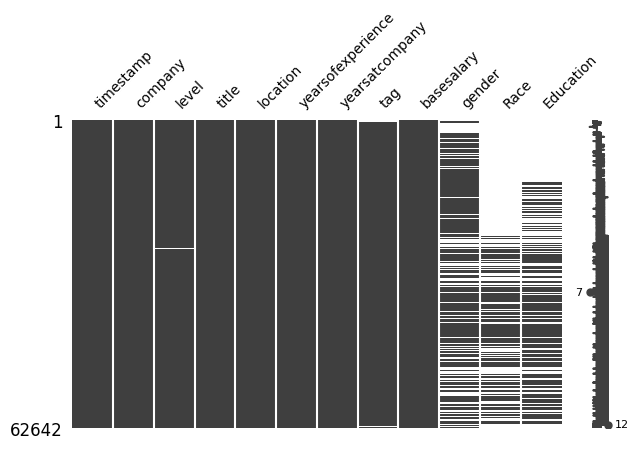

In [3]:
import matplotlib.pyplot as plt
import missingno as msno
msno.matrix(df, figsize=(7, 4), fontsize=10)
plt.show()

### Remove specific missing values

In [4]:
df = remove_nan(df,['level','company','basesalary','tag']).drop_nan()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61667 entries, 409 to 62641
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   timestamp          61667 non-null  object 
 1   company            61667 non-null  object 
 2   level              61667 non-null  object 
 3   title              61667 non-null  object 
 4   location           61667 non-null  object 
 5   yearsofexperience  61667 non-null  float64
 6   yearsatcompany     61667 non-null  float64
 7   tag                61667 non-null  object 
 8   basesalary         61667 non-null  float64
 9   gender             42682 non-null  object 
 10  Race               22353 non-null  object 
 11  Education          30277 non-null  object 
dtypes: float64(3), object(9)
memory usage: 6.1+ MB


### Fill categorical features

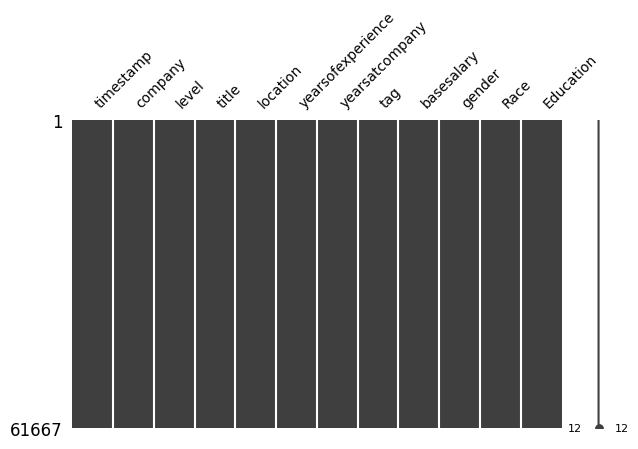

In [5]:
df = nan_filler(df,['gender','Race','Education']).fill_unavailable()
msno.matrix(df, figsize=(7, 4), fontsize=10)
plt.show()

In [6]:
#pd.to_datetime(df['timestamp'])

## 2. Creation of Features

### 2.1 Features of time

In [7]:
df = time(df,'timestamp').year()
df = time(df,'timestamp').month()
df = time(df,'timestamp').day()

### 2.2 Features of clusters

In [8]:
#cluster(df, 'basesalary', 'level').make_cluster()
df = cluster(df, 'basesalary', 'company').make_cluster()
df = cluster(df, 'basesalary', 'level').make_cluster()

### 2.3 Creating dummies

In [9]:
df.loc[df['gender'] == 'Title: Senior Software Engineer', 'gender'] = 'Unavailable'
df = dummies(df,['title','gender', 'Race', 'Education']).get_dum()

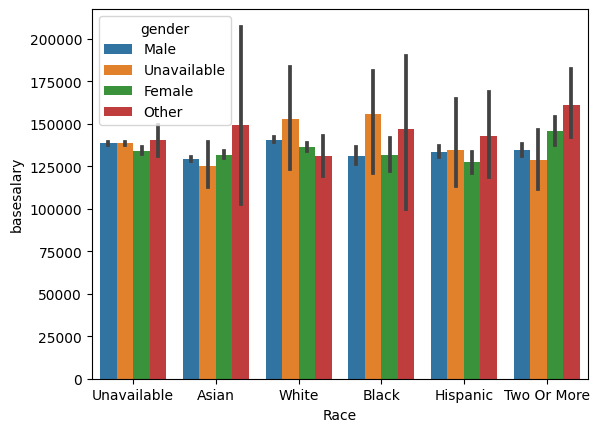

In [10]:
import seaborn as sns
sns.barplot(x = 'Race', hue =  'gender', y = 'basesalary', data = df)
plt.show()

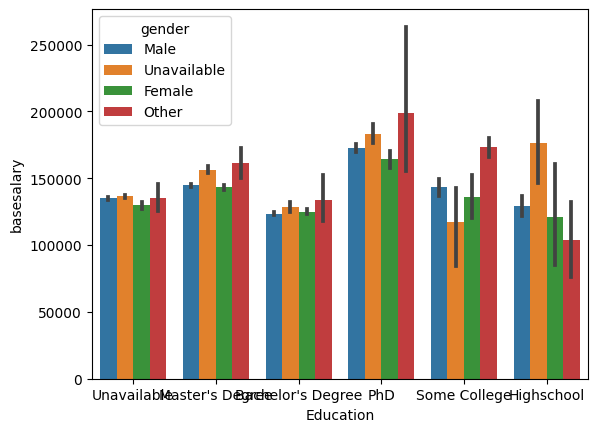

In [11]:
sns.barplot(x = 'Education', hue =  'gender', y = 'basesalary', data = df)
plt.show()

### Practitioner section

In [12]:
# I remove very low salary values which could be results of failed scraping, and very high values (2% of outliers)
df = df[df['basesalary'] > 10 ]
q98 = np.quantile(df['basesalary'],0.98)
df.loc[ df.basesalary >q98 , 'basesalary'] =q98

#years_ratio
df['years_ratio'] = 0
df.loc[ df['yearsofexperience'] >0 ,'years_ratio'] = df['yearsatcompany']/df['yearsofexperience']

#cities
common_locs = df.value_counts('location').head(10).reset_index().location.to_list()
df = df.join(pd.get_dummies(df.loc[df.location.isin(common_locs), 'location'] ) )
df[common_locs] = df[common_locs].fillna(0)

#countries
df['country'] = df['location'].str.split(pat=',').apply(lambda x:x[-1][1:])
df.loc[ df['country'].str.len() == 2,'country'] = 'US'
df['country'].value_counts().head(6)

#one_hot the common ones
df = df.join(pd.get_dummies(df['country'])[['US', 'India', 'Canada', 'United Kingdom', 'Germany']])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59459 entries, 0 to 61666
Data columns (total 61 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   timestamp                           59459 non-null  datetime64[ns]
 1   company                             59459 non-null  object        
 2   level                               59459 non-null  object        
 3   title                               59459 non-null  object        
 4   location                            59459 non-null  object        
 5   yearsofexperience                   59459 non-null  float64       
 6   yearsatcompany                      59459 non-null  float64       
 7   tag                                 59459 non-null  object        
 8   basesalary                          59459 non-null  float64       
 9   gender                              59459 non-null  object        
 10  Race                  

## 3. Model

### 3.1 Split into train and test

In [14]:
X = df[['yearsofexperience','years_ratio','yearsatcompany','company_encoded', 'level_encoded',
        'timestamp_month','timestamp_year', 'gender_Male',  'gender_Other', 'gender_Unavailable', 
        'Race_Black', 'Race_Hispanic', 'Race_Two Or More', 'Race_Unavailable', 'Race_White',
        'Education_Highschool', 'Education_Master\'s Degree', 'Education_PhD',
        'Education_Some College', 'Education_Unavailable',
        'title_Data Scientist','title_Hardware Engineer', 'title_Human Resources', 'title_Management Consultant',
        'title_Marketing', 'title_Mechanical Engineer', 'title_Product Designer','title_Product Manager', 'title_Recruiter', 
        'title_Sales', 'title_Software Engineer','title_Software Engineering Manager', 'title_Solution Architect',
        'title_Technical Program Manager',
        'US', 'India', 'Canada', 'United Kingdom', 'Germany' # improved a lot by adding countries! 
        ]
        + common_locs
        ]

y = df['basesalary']

In [17]:
X_train, X_test, y_train, y_test = split(X, y).split_train_test()

### 3.2 Regression and prediction

## 4. Evaluation